#  Indirect dark matter detection detection constatints in the SDFDM

We expect here degenerate masses so we must be carefull about the DM particles that is registered by micrOMEGAS:

We need to edit prtcls1.mld to have the righ order with Nv0 appearing first

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import numpy as np
import os, sys, inspect
import commands
from hep_new import *
import pdg_series
#from indirectdirect import *
from straightfits import *
from multicurvefit import *
import stu_sdfdm as stu
import time
from matplotlib.colors import LogNorm
Omega_h2_EXP=np.array([0.1197-0.0044,0.1197,0.1197+0.0044])
def Oh2(df,Omega_h2_EXP=Omega_h2_EXP):
    return df[ np.logical_and(df.Omega_h2<Omega_h2_EXP[2],df.Omega_h2>Omega_h2_EXP[0]) ].reset_index(drop=True)

In [10]:
a=hep(MODEL='SimplifiedDMSDFDM')
IGNORE_CELL=True
if IGNORE_CELL:
    scan=False

# Jump directly to the analysis [here](#analysis),
or follow to the next cell to re-create the main DataFrame

## Feynrules implementation
[Preliminary Analysis](../../../../../2016/micromegas_feynrules/correr_micrOMEGAs-markov.ipynb)

See also full results with user galcen in fisica? or gfif?


## Benchmark point

We choose a benchmark point with the following features
* Large $\langle\sigma v\rangle$
* Right relic density

In [4]:
from run_feynrules_SDFM import *

In [5]:
%%bash
cd ../micromegas/SDFDM
make main=main.c > /dev/null

## Parameter scan

`a-object` is an object with many attributes and methods. Use the tab to explore them. Some of them are
* a.Series: [pandas](http://pandas.pydata.org/) Series object with the "relevant" variables 
* a.LHA: Input LesHouces file as [pyslha](https://pypi.python.org/pypi/pyslha/) object
* a.runSPheno() -> a.LHA_out: return LHA output files as [pyslha](https://pypi.python.org/pypi/pyslha/) object
* a.runmicromegas() -> a.runSPheno() -> Updated the `a-object`  with micrOMEGAS "relevant" output

List of constraints for DM=37 GeV and MD=200 GeV
* $\sigma(\chi_{2,3}^0,\chi^\pm)\operatorname{Br}(\chi^\pm \to \chi_1^0 W^\pm)\operatorname{Br}(\chi_2^0 \to \chi_1^0 Z)<0.3\ \text{pb}$ from fig. 15 of [arXiv:1411.1335](http://arxiv.org/pdf/1411.1335v2)
## Check benchmark point

In [5]:
#IGNORE_CELL=False
if not IGNORE_CELL:
    v=a.vev
    #lambda_1=0.13
    if 1==1:
        mdf=-214.058784
        ps=pd.Series()
        MN=29.248824
        tanb=24.215051
        lam=0.711271
        lu=lam*np.sin(np.arctan(tanb))
        ld=lam*np.cos(np.arctan(tanb))
        devnull=commands.getoutput('rm -f SPheno.spc.%s' %a.MODEL)
        a.LHA.blocks['SPHENOINPUT'].entries[55]='0               # Calculate one loop masses'
        a.LHA.blocks['MINPAR'][2]='%0.8E       # MDF' %mdf
        a.LHA.blocks['MINPAR'][3]='%0.8E       # MnINPUT' %MN
        a.LHA.blocks['MINPAR'][4]='%0.8E       # lamuINPUT' %lu
        a.LHA.blocks['MINPAR'][5]='%0.8E       # lamdINPUT' %ld
        moc=a.runmicromegas(Direct_Detection=True)
        #print 'Omega h^2, SI proton, neutron, MChi =',a.Series.Omega_h2,a.Series.proton_SI,a.Series.neutron_SI,\
        a.LHA_out.blocks['MASS'][a.pdg.pdg_name.Chi_1]
    #manual pdgs:
        a.pdg['Frep']=-210000601
        mof=run_feynrules_SDFDM(MDF = -a.Series.MDF,MN = a.Series.MnINPUT,\
                            lu = a.Series.lamuINPUT,ld = a.Series.lamdINPUT ,v=a.vev)
    #implement sigma_v
        mo=a.micromegas_output(mof['Full'])
        a.branchings(a.LHA_out.decays,min_pdg=25)
        #print 'Omega h^2, SI proton, sigmav,Br_inv  =',mo.Omega_h2,mo.proton.SI,mo.sigmav,a.Br_names['h0 ->  Chi_1 Chi_1']
        #print a.Br_names['Fre ->  Chi_1 W-'],a.Br_names['Cha.Seriesi_2 ->  Chi_1 Z0']
        a.Series['sigma_chi0_chipm']=0.3 #pb from fig. 15 of arXiv:1411.1335
        a.Series['Chi_1']=a.LHA_out.blocks['MASS'][a.pdg.pdg_name.Chi_1]
        a.Series['Chi_2']=a.LHA_out.blocks['MASS'][a.pdg.pdg_name.Chi_2]
        a.Series['Chi_3']=a.LHA_out.blocks['MASS'][a.pdg.pdg_name.Chi_3]
        a.Series['Fre']=a.LHA_out.blocks['MASS'][a.pdg.pdg_name.Fre]
        ps=ps.append(a.Series)
        ps=ps.append(a.Br_names)
        for mix in [k for k  in mof['Full_Input'].keys() if re.search('N[1-3][1-3]',k)]:
            ps[mix]=mof['Full_Input'][mix]
        ps=ps.append(a.micromegas.rename({'Omega_h2':'Omega_h2_mo','proton_SI':'proton_SI_mo','neutron_SI':'neutron_SI_mo'}))

In [11]:
if not IGNORE_CELL:
    print a.Series

In [36]:
if not IGNORE_CELL:
    scan=True # If false load the data from the saved scan files below

In [ ]:
start=time.time()
if scan and not IGNORE_CELL:
    pf=pd.DataFrame()
    fulld=pd.DataFrame()
    v=a.vev
    #lambda_1=0.13
    mdf=-200; MN=40; tanb=100.;lam=0.35
    npoints=10000
    i=0
    for mdf in -np.logspace(np.log10(100),np.log10(1000),npoints):
        i=i+1
        if i%1000==0: print i
        ps=pd.Series()
        MN=np.random.uniform(10,50)
        tanb=np.random.uniform(1,100)
        lam=np.random.uniform(0.1,3)
        lu=lam*np.sin(np.arctan(tanb))
        ld=lam*np.cos(np.arctan(tanb))
        devnull=commands.getoutput('rm -f SPheno.spc.%s' %a.MODEL)
        a.LHA.blocks['SPHENOINPUT'].entries[55]='0               # Calculate one loop masses'
        a.LHA.blocks['MINPAR'][2]='%0.8E       # MDF' %mdf
        a.LHA.blocks['MINPAR'][3]='%0.8E       # MnINPUT' %MN
        a.LHA.blocks['MINPAR'][4]='%0.8E       # lamuINPUT' %lu
        a.LHA.blocks['MINPAR'][5]='%0.8E       # lamdINPUT' %ld
        moc=a.runmicromegas(Direct_Detection=True)
        #print 'Omega h^2, SI proton, neutron, MChi =',a.Series.Omega_h2,a.Series.proton_SI,a.Series.neutron_SI,\
        a.LHA_out.blocks['MASS'][a.pdg.pdg_name.Chi_1]
    #manual pdgs:
        a.pdg['Frep']=-210000601
        #mof=run_feynrules_SDFDM(MDF = -a.Series.MDF,MN = a.Series.MnINPUT,\
        #                    lu = a.Series.lamuINPUT,ld = a.Series.lamdINPUT ,v=a.vev)
    #implement sigma_v
        #mo=a.micromegas_output(mof['Full'])
        a.branchings(a.LHA_out.decays,min_pdg=25)
        #print 'Omega h^2, SI proton, sigmav,Br_inv  =',mo.Omega_h2,mo.proton.SI,mo.sigmav,a.Br_names['h0 ->  Chi_1 Chi_1']
        #print a.Br_names['Fre ->  Chi_1 W-'],a.Br_names['Cha.Seriesi_2 ->  Chi_1 Z0']
        a.Series['sigma_chi0_chipm']=0.3 #pb from fig. 15 of arXiv:1411.1335
        a.Series['Chi_1']=a.LHA_out.blocks['MASS'][a.pdg.pdg_name.Chi_1]
        a.Series['Chi_2']=a.LHA_out.blocks['MASS'][a.pdg.pdg_name.Chi_2]
        a.Series['Chi_3']=a.LHA_out.blocks['MASS'][a.pdg.pdg_name.Chi_3]
        a.Series['Fre']=a.LHA_out.blocks['MASS'][a.pdg.pdg_name.Fre]
        ps=ps.append(a.Series)
        ps=ps.append(a.Br_names)
        #ps=ps.append(  mo.rename( {'Omega_h2':'Omega_h2_mo','proton_SI':'proton_SI_mo','neutron_SI':'neutron_SI_mo',\
        #                           'proton_SD':'proton_SD_mo','neutron_SD':'neutron_SD_mo','sigmav':'sigmav_mo',\
        #                             } )  )
        pf=pf.append(ps,ignore_index=True)
        pf=pf.fillna(0)
        #Full backup of data: WARNING: HUGE File
        fulls=pd.Series()
        if os.path.isfile('SPheno.spc.%s' %a.MODEL):
            f=open('SPheno.spc.%s' %a.MODEL).read()
            fulls['SPheno']=f
            fulls['micromegas']=moc
            
        fulld=fulld.append(fulls,ignore_index=True)

stop=time.time()
trun=stop-start
pd.DataFrame({'t':[trun]}).to_csv('trun.csv')

In [57]:
if scan and not IGNORE_CELL: 
    pf.to_csv('scan_full_4.csv',index=False)
    fulld.to_pickle('scan_full_4.pkl')

In [91]:
if not scan: #load the data from the saved scan files
    pf=pd.read_csv('scan_full.csv')
    pf=pf.append(pd.read_csv('scan_full_2.csv'))
    #pf=pd.read_csv('scan_full_3.csv')
    
    pf=pf.append(pd.read_csv('scan_full_3.csv'))
    pf=pf.fillna(0)
    pf['ID_br:~Chi1,~Chi1 -> d3 D3']=pf['ID_br:~chi,~chi > b b~']
    pf['ID_br:~Chi1,~Chi1 -> u2 U2']=pf['ID_br:~chi,~chi > c c~']
    pf['ID_br:~Chi1,~Chi1 -> e3 E3']=pf['ID_br:~chi,~chi > ta t']
    pf=pf.append(pd.read_csv('scan_full_4.csv'))
    pf=pf.append(pd.read_csv('scan_full_5.csv'))
    
pf=pf.sort_values('Chi_1')
pf=pf.reset_index(drop=True)
pf.shape

(37061, 189)

## Prepare full data frame

In [92]:
pf['z2_sigmav']=pf.Omega_h2**2/Omega_h2_EXP[1]**2*pf.sigmav #sigmav calculated from feynrules implemenation
pf['tanb']=pf.lamuINPUT/pf.lamdINPUT
pf['lambda']=np.sqrt(pf.lamuINPUT**2+pf.lamdINPUT**2)
pf['lam']=pf['lambda']

## Temporal: Filter unimportant points

In [99]:
pf=pf[pf.Omega_h2<=Omega_h2_EXP[2]]
pf=pf[np.logical_and(pf.Chi_1.abs()<50,pf.z2_sigmav>2E-28)]
pf.shape

(8773, 193)

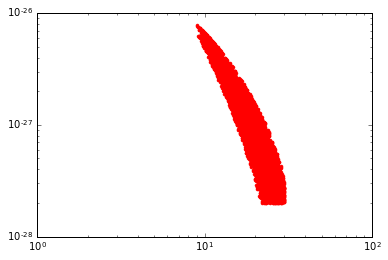

In [100]:
plt.loglog(pf.Chi_1,pf.z2_sigmav,'r.')

### Full data set

In [101]:
start=time.time()
pf['T_par']=stu.stumap(pf.MnINPUT.values,pf.MDF.values,pf.lam.values,pf.tanb.values,vev=a.vev) #T is transpose
print 'Execution Time:',time.time()-start

Execution Time: 154.276172161


In [102]:
pf['DD_SI']=0
if pf[pf.proton_SI>pf.neutron_SI].shape[0]==0:
    pf['DD_SI']=pf.neutron_SI
else:
    for i in range(pf.shape[0]):
        pf=pf.reset_index(drop=True)
        pf.loc[i,'DD_SI']=max(pf.proton_SI[i],pf.neutron_SI[i])

In [103]:
pf['z_DD_SI']=pf.Omega_h2/Omega_h2_EXP[1]*pf.DD_SI


In [104]:
pf[logical_and(pf.Chi_1.abs()<50,pf.z2_sigmav>2E-28)].shape

(8773, 196)

In [105]:
LUX=multicurvefit()
LUX.read_json('lux2016.json')

In [106]:
AMS=multicurvefit()
AMS.read_json('ID_max.json')

In [107]:
LHC_cs=multicurvefit()
LHC_cs.read_json('SDFDM_cs.json')

In [108]:
LHC_exc_cs=multicurvefit()
LHC_exc_cs.read_json('SDFDM_exc_cs.json')

In [109]:
pf['lux_SI']=LUX(pf.Chi_1,verbose=False)

In [110]:
pf['AMS_ID_bb']=AMS(pf['Chi_1'],verbose=False)

In [111]:
pf['LHC_cs']=LHC_cs(np.abs(pf.MDF),verbose=False)

In [112]:
pf['LHC_cs_br']=pf.LHC_cs*pf['Chi_2 ->  Chi_1 Z0']*pf['Fre ->  Chi_1 W-']

In [113]:
pf['LHC_exc_cs']=LHC_exc_cs(abs(pf.MDF),verbose=False)

In [114]:
pff=pf

In [115]:
pff.shape

(8773, 201)

### Save extended DataFrame

In [112]:
pf.to_csv('pf.csv.bz2',compression='bz2')

#  Start analysis
<a id='analysis'></a>
##  Recover extended DataFrame

In [113]:
pff=pd.read_csv('pf.csv.bz2')
pff.shape

(36556, 201)

In [116]:
start=time.time()
pff['T_par_m']=stu.stumap(pff.MnINPUT.values,-pff.MDF.values,pff.lam.values,pff.tanb.values,vev=a.vev) #T is transpose
print 'Execution Time:',time.time()-start

Execution Time: 109.888069153


### Main Columns
* `z_DD_SI`: Reescaled indirect detection cross section 

In [117]:
Omega_h2_EXP=np.array([0.1197-0.0044,0.1197,0.1197+0.0044])
LUX=multicurvefit()
LUX.read_json('lux2016.json')
AMS=multicurvefit()
AMS.read_json('ID_max.json')
LHC_cs=multicurvefit()
LHC_cs.read_json('SDFDM_cs.json')
LHC_exc_cs=multicurvefit()
LHC_exc_cs.read_json('SDFDM_exc_cs.json')

## Constraints
* $\Omega h^2\le(\Omega h^2)_{\text{Planck}}$, at one $\sigma$

To add to hep constants:

In [118]:
h_to_AA=2.270E-03
R_AA=np.array([1.15-0.25,1.15,1.15+0.27])

###  Main cuts exploration

In [119]:

pf=pff[pff.Omega_h2<Omega_h2_EXP[2]].reset_index(drop=True)
pfe=pff[pff.Omega_h2>Omega_h2_EXP[2]].reset_index(drop=True)
print pff.shape[0],np.abs(pff.Chi_1.min())
opf=Oh2(pff) #pf[ np.logical_and(pf.Omega_h2<Omega_h2_EXP[2],pf.Omega_h2>Omega_h2_EXP[0]) ].reset_index(drop=True)
print opf.shape

8773 8.99903836
(706, 202)


We vary the parameters as...

The parameter space is illustrated below whit the defined color conventions for points with too large relic density, proper relic density and small relic density

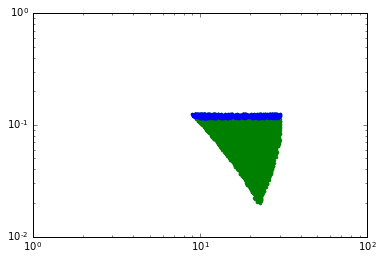

In [120]:
plt.loglog(pfe.Chi_1,pfe.Omega_h2,'r.')
plt.loglog(pf.Chi_1,pf.Omega_h2,'g.')
plt.loglog(opf.Chi_1,opf.Omega_h2,'b.')

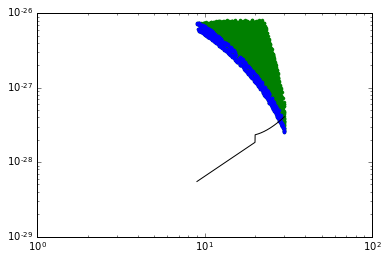

In [121]:
plt.loglog(pfe.Chi_1,pfe.sigmav,'r.')
plt.loglog(pf.Chi_1,pf.sigmav,'g.')
plt.loglog(opf.Chi_1,opf.sigmav,'b.')
plt.loglog(pf.Chi_1,pf.AMS_ID_bb,'k-' )

(2.2, 400)

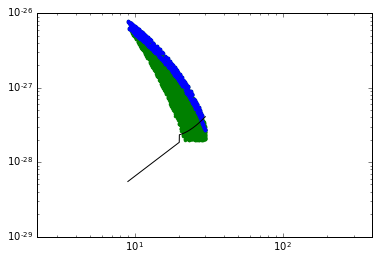

In [122]:
plt.loglog(pfe.Chi_1,pfe.z2_sigmav,'r.')
plt.loglog(pf.Chi_1,pf.z2_sigmav,'g.')
plt.loglog(opf.Chi_1,opf.z2_sigmav,'b.')
plt.loglog(pf.Chi_1,pf.AMS_ID_bb,'k-' )
plt.loglog(pfe.Chi_1,pfe.AMS_ID_bb,'k-' )
plt.xlim(2.2,400)

(1e-30, 1e-26)

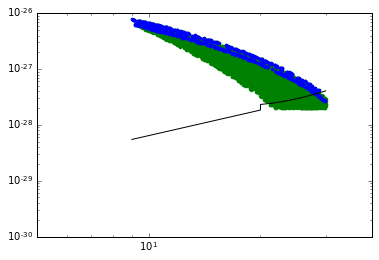

In [123]:
plt.loglog(pfe.Chi_1,pfe.z2_sigmav,'r.')
plt.loglog(pf.Chi_1,pf.z2_sigmav,'g.')
plt.loglog(opf.Chi_1,opf.z2_sigmav,'b.')
plt.loglog(pf.Chi_1,pf.AMS_ID_bb,'k-' )
plt.xlim(5,40)
plt.ylim(1E-30,1E-26)

(1e-21, 0.0001)

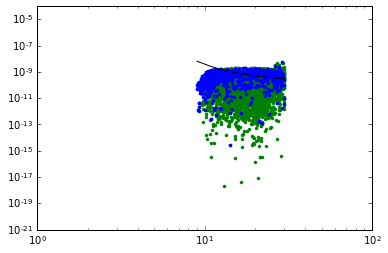

In [124]:
plt.loglog(pfe.Chi_1,pfe.z_DD_SI,'r.')
plt.loglog(pf.Chi_1,pf.z_DD_SI,'g.')
plt.loglog(opf.Chi_1,opf.z_DD_SI,'b.')
plt.loglog(pf.Chi_1,pf.lux_SI,'k-' )
plt.loglog(pfe.Chi_1,pfe.lux_SI,'k-' )
plt.ylim(1E-21,1E-4)

## Proposed cuts
* a: relic density 
* b: Electroweak precision tests
* c: $\operatorname{Br}_{\text{inv}}$
* d: $R_{\gamma\gamma}$
* e: Collider physics
* f: Direct detection
* g: Indirect detection

In [125]:
nl=17
print '-'*nl
print '| all |', pff.shape[0],'  |'
cf=pd.Series()
cf['a']=pff[pff.Omega_h2<=Omega_h2_EXP[2]]
print '-'*nl
print '| a   |', cf.a.shape[0],'  |'
cf['b']=cf.a[cf.a.T_par<0.2]
print '-'*nl
print '| b   |', cf.b.shape[0],'  |'
cf['c']=cf.b[cf.b['h0 ->  Chi_1 Chi_1']<0.19]
print '-'*nl
print '| c   |', cf.c.shape[0],'  |'
cf['d']=cf.c[np.logical_and(cf.c['h0 ->  PHOT PHOT']/h_to_AA>R_AA[0],cf.c['h0 ->  PHOT PHOT']/h_to_AA<R_AA[2])]
print '-'*nl
print '| d   |', cf.d.shape[0],'  |'
cf['e']=cf.d[cf.d.LHC_cs_br<cf.d.LHC_exc_cs]
print '-'*nl
print '| e   |', cf.e.shape[0],'  |'
cf['f']=cf.e[cf.e.z_DD_SI<cf.e.lux_SI]
print '-'*nl
print '| f   |', cf.f.shape[0],'   |'
print '-'*nl

-----------------
| all | 8773   |
-----------------
| a   | 8773   |
-----------------
| b   | 762   |
-----------------
| c   | 70   |
-----------------
| d   | 62   |
-----------------
| e   | 19   |
-----------------
| f   | 19    |
-----------------


##  Parameter space after all cuts

(1e-29, 1e-25)

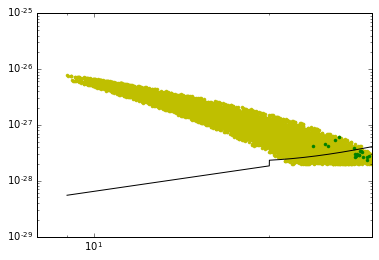

In [126]:
cut='e'
ocf=pd.Series()
#ocf[cut]=Oh2(cf[cut])
plt.loglog(pff.Chi_1,pff.z2_sigmav,'y.')
plt.loglog(cf[cut].Chi_1,cf[cut].z2_sigmav,'g.')
#plt.loglog(ocf[cut].Chi_1,ocf[cut].z2_sigmav,'b.')
#cut='b'
#ocf[cut]=Oh2(cf[cut])
#plt.loglog(cf[cut].Chi_1,cf[cut].z2_sigmav,'r.')
#plt.loglog(ocf[cut].Chi_1,ocf[cut].z2_sigmav,'c.')
plt.loglog(pf.Chi_1,pf.AMS_ID_bb,'k-' )
plt.loglog(pfe.Chi_1,pfe.AMS_ID_bb,'k-' )
plt.xlim(2.2,400)
plt.xlim(8.,30)
plt.ylim(1E-29,1E-25)

(1e-29, 1e-25)

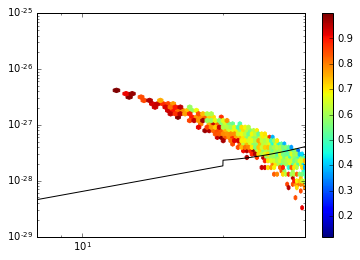

In [28]:
cut='a'
cf[cut]=cf[cut][cf[cut].z2_sigmav>0]
cfp=cf[cut][np.logical_and(cf[cut].lam<1.,cf[cut].Chi_1<50)]
cfp=cfp[cfp.MDF<200]
#plt.loglog(cf[cut].Chi_1,cf[cut].z2_sigmav,'c.')
plt.hexbin(cfp.Chi_1,cfp.z2_sigmav,cfp.lam,xscale='lin',yscale='log')
plt.colorbar()
plt.loglog(pff.Chi_1,pff.AMS_ID_bb,'k-' )
plt.xlim(8.,30)
plt.ylim(1E-29,1E-25)

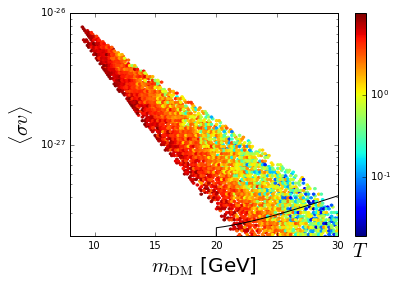

In [191]:
cut='a'
#cf[cut]=cf[cut][cf[cut].z2_sigmav>0]
cfp=cf[cut][cf[cut].T_par<10]#[np.logical_and(cf[cut].lam<1.,cf[cut].Chi_1<50)]
#cfp=cfp[cfp.MDF<200]
#plt.loglog(cf[cut].Chi_1,cf[cut].z2_sigmav,'c.')
plt.hexbin(cfp.Chi_1,cfp.z2_sigmav,cfp.T_par,xscale='lin',yscale='log',norm=LogNorm(),gridsize = 100)
pltc=plt.colorbar()
plt.semilogy(pff.Chi_1,pff.AMS_ID_bb,'k-' )
plt.ylabel(r'$\langle\sigma v\rangle$',size=20)
plt.xlabel(r'$m_{\rm DM}$ [GeV]',size=20)
pltc.ax.set_xlabel('$T$',size=20)
plt.xlim(8.,30)
plt.ylim(2E-28,1E-26)
plt.savefig('T.pdf')

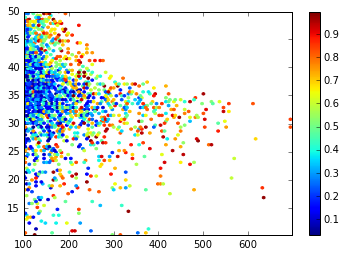

In [199]:
cfp=cf[cut][cf[cut].T_par<1]
plt.hexbin(-cfp.MDF,cfp.MnINPUT,cfp.T_par,xscale='lin',yscale='lin')#,norm=LogNorm(),gridsize = 100)
plt.colorbar()

(1e-28, 3e-27)

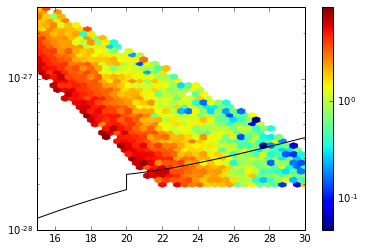

In [174]:
cut='a'
#cf[cut]=cf[cut][cf[cut].z2_sigmav>0]
cfp=cf[cut]#[np.logical_and(cf[cut].lam<1.,cf[cut].Chi_1<50)]
#cfp=cfp[cfp.MDF<200]
#plt.loglog(cf[cut].Chi_1,cf[cut].z2_sigmav,'c.')
plt.hexbin(cfp.Chi_1,cfp.z2_sigmav,cfp.T_par,xscale='lin',yscale='log',norm=LogNorm(),gridsize = 50)
plt.colorbar()
plt.semilogy(pff.Chi_1,pff.AMS_ID_bb,'k-' )
plt.xlim(15.,30)
plt.ylim(1E-28,3E-27)

(1e-28, 1e-26)

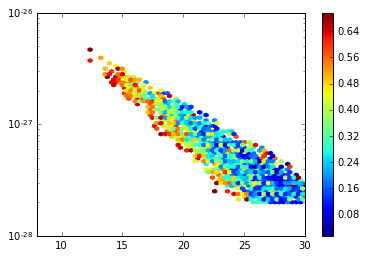

In [173]:
cfp=cfp[cfp.T_par<0.7]
plt.hexbin(cfp.Chi_1,cfp.z2_sigmav,cfp.T_par,xscale='lin',yscale='log',gridsize = 50)#,norm=LogNorm())
plt.colorbar()
plt.xlim(8.,30)
plt.ylim(1E-28,1E-26)

In [157]:
plt.hexbin?

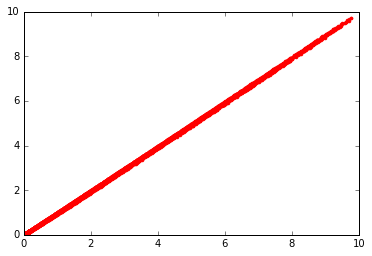

In [131]:
plt.plot(pf.T_par,pf.T_par_m,'r.')

In [291]:
cf[cut].z2_sigmav.values.min()

0.0

In [215]:
cf.f.shape

(1370, 201)

In [30]:
ncf=pd.Series()
for cut in 'abcdef':
    ncf[cut]=cf[cut][cf[cut].z2_sigmav>cf[cut].AMS_ID_bb]

(1e-29, 1e-25)

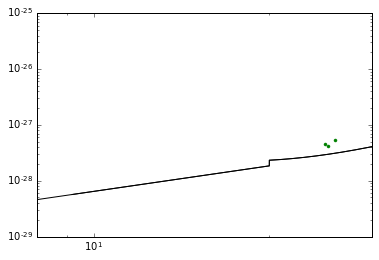

In [36]:
cut='f'
plt.loglog(ncf[cut].Chi_1,ncf[cut].z2_sigmav,'g.')
plt.loglog(pf.Chi_1,pf.AMS_ID_bb,'k-' )
plt.loglog(pfe.Chi_1,pfe.AMS_ID_bb,'k-' )
plt.xlim(8.,30)
plt.ylim(1E-29,1E-25)

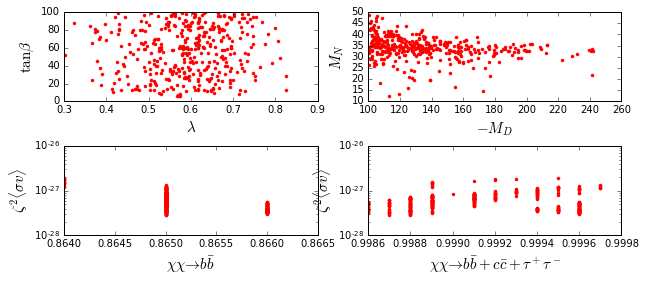

In [37]:
spf=ncf.b
#fig, axes = plt.subplots(nrows=2, ncols=2)
#fig.tight_layout()
fig=plt.figure()
fig.subplots_adjust(hspace=0.5,wspace=0.2,left=0.01,right=1.3)
fig.add_subplot(221)
plt.plot(spf['lambda'],spf.tanb,'r.')
plt.xlabel(r'$\lambda$',size=15)
plt.ylabel(r'$\tan\beta$',size=15)
fig.add_subplot(222)
plt.plot(-spf.MDF,spf.MnINPUT,'r.')
plt.xlabel(r'$-M_D$',size=15)
plt.ylabel(r'$M_N$',size=15)
fig.add_subplot(223)
plt.semilogy(spf['ID_br:~Chi1,~Chi1 -> d3 D3'],spf.z2_sigmav,'r.')
plt.xlabel(r'$\chi\chi\to b\bar{b}$',size=15)
plt.ylabel(r'$\zeta^2\langle\sigma v\rangle$',size=15)
fig.add_subplot(224)
plt.semilogy(spf['ID_br:~Chi1,~Chi1 -> d3 D3']+spf['ID_br:~Chi1,~Chi1 -> u2 U2']+spf['ID_br:~Chi1,~Chi1 -> e3 E3'],spf.z2_sigmav,'r.')
plt.xlabel(r'$\chi\chi\to b\bar{b}+c \bar{c}+\tau^+\tau^-$',size=15)
plt.ylabel(r'$\zeta^2\langle\sigma v\rangle$',size=15)

### Final scan

In [ ]:
start=time.time()
if 1==1:#if scan and not IGNORE_CELL:
    pf=pd.DataFrame()
    fulld=pd.DataFrame()
    v=a.vev
    #lambda_1=0.13
    mdf=-200; MN=40; tanb=100.;lam=0.35
    npoints=10000
    i=0;j=0
    for mdf in -np.logspace(np.log10(100),np.log10(300),npoints):
        i=i+1
        if i%1000==0: print i
        ps=pd.Series()
        MN=np.random.uniform(10,50)
        tanb=np.random.uniform(5,100)
        lam=np.random.uniform(0.1,1)
        lu=lam*np.sin(np.arctan(tanb))
        ld=lam*np.cos(np.arctan(tanb))
        devnull=commands.getoutput('rm -f SPheno.spc.%s' %a.MODEL)
        a.LHA.blocks['SPHENOINPUT'].entries[55]='0               # Calculate one loop masses'
        a.LHA.blocks['MINPAR'][2]='%0.8E       # MDF' %mdf
        a.LHA.blocks['MINPAR'][3]='%0.8E       # MnINPUT' %MN
        a.LHA.blocks['MINPAR'][4]='%0.8E       # lamuINPUT' %lu
        a.LHA.blocks['MINPAR'][5]='%0.8E       # lamdINPUT' %ld
        moc=a.runmicromegas(Direct_Detection=True)
        #print 'Omega h^2, SI proton, neutron, MChi =',a.Series.Omega_h2,a.Series.proton_SI,a.Series.neutron_SI,\
        a.LHA_out.blocks['MASS'][a.pdg.pdg_name.Chi_1]
    #manual pdgs:
        a.pdg['Frep']=-210000601
        #mof=run_feynrules_SDFDM(MDF = -a.Series.MDF,MN = a.Series.MnINPUT,\
        #                    lu = a.Series.lamuINPUT,ld = a.Series.lamdINPUT ,v=a.vev)
    #implement sigma_v
        #mo=a.micromegas_output(mof['Full'])
        a.branchings(a.LHA_out.decays,min_pdg=25)
        #print 'Omega h^2, SI proton, sigmav,Br_inv  =',mo.Omega_h2,mo.proton.SI,mo.sigmav,a.Br_names['h0 ->  Chi_1 Chi_1']
        #print a.Br_names['Fre ->  Chi_1 W-'],a.Br_names['Cha.Seriesi_2 ->  Chi_1 Z0']
        a.Series['sigma_chi0_chipm']=0.3 #pb from fig. 15 of arXiv:1411.1335
        a.Series['Chi_1']=a.LHA_out.blocks['MASS'][a.pdg.pdg_name.Chi_1]
        a.Series['Chi_2']=a.LHA_out.blocks['MASS'][a.pdg.pdg_name.Chi_2]
        a.Series['Chi_3']=a.LHA_out.blocks['MASS'][a.pdg.pdg_name.Chi_3]
        a.Series['Fre']=a.LHA_out.blocks['MASS'][a.pdg.pdg_name.Fre]
        ps=ps.append(a.Series)
        ps=ps.append(a.Br_names)
        #ps=ps.append(  mo.rename( {'Omega_h2':'Omega_h2_mo','proton_SI':'proton_SI_mo','neutron_SI':'neutron_SI_mo',\
        #                           'proton_SD':'proton_SD_mo','neutron_SD':'neutron_SD_mo','sigmav':'sigmav_mo',\
        #                             } )  )
        C1=ps.Omega_h2<Omega_h2_EXP[2]
        C2=stu.stumap(ps.MnINPUT,ps.MDF,np.sqrt(ps.lamuINPUT**2+ps.lamdINPUT**2),ps.lamuINPUT/ps.lamdINPUT,vev=a.vev)<0.2 
        C3=ps.Omega_h2**2/Omega_h2_EXP[1]**2*ps.sigmav>2E-28
        if C1 and C2 and C3:
            pf=pf.append(ps,ignore_index=True)
            pf=pf.fillna(0)
            j=j+1
            print 'candidate:',j
        #Full backup of data: WARNING: HUGE File
        

pf.to_csv('scan_full_5.csv')
stop=time.time()
trun=stop-start
pd.DataFrame({'t':[trun]}).to_csv('trun.csv',index=False)

candidate: 1
candidate: 2
candidate: 3
candidate: 4
candidate: 5
candidate: 6
candidate: 7
candidate: 8
candidate: 9
candidate: 10
candidate: 11
candidate: 12
candidate: 13
candidate: 14
candidate: 15
candidate: 16
candidate: 17
candidate: 18
candidate: 19
candidate: 20
candidate: 21
candidate: 22
candidate: 23
candidate: 24
candidate: 25
candidate: 26
candidate: 27
candidate: 28
candidate: 29
candidate: 30
candidate: 31
candidate: 32
candidate: 33
candidate: 34
candidate: 35
candidate: 36
candidate: 37
candidate: 38
candidate: 39
candidate: 40
candidate: 41
candidate: 42
candidate: 43
candidate: 44
candidate: 45
candidate: 46
candidate: 47
candidate: 48
candidate: 49
candidate: 50
candidate: 51
candidate: 52
candidate: 53
candidate: 54
candidate: 55
candidate: 56
candidate: 57
candidate: 58
candidate: 59
candidate: 60
candidate: 61
candidate: 62
candidate: 63
candidate: 64
candidate: 65
candidate: 66
candidate: 67
candidate: 68
candidate: 69
candidate: 70
candidate: 71
candidate: 72
c

/usr/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:321: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)


candidate: 174
candidate: 175
candidate: 176
candidate: 177
candidate: 178
candidate: 179
candidate: 180
candidate: 181
candidate: 182
candidate: 183
candidate: 184
candidate: 185
candidate: 186
candidate: 187
candidate: 188
candidate: 189
candidate: 190
candidate: 191
candidate: 192
candidate: 193
candidate: 194
candidate: 195
candidate: 196
candidate: 197
candidate: 198
candidate: 199
candidate: 200
candidate: 201
candidate: 202
2000
candidate: 203
candidate: 204
candidate: 205
candidate: 206
candidate: 207
candidate: 208
candidate: 209
candidate: 210
candidate: 211
candidate: 212
candidate: 213
candidate: 214
candidate: 215
candidate: 216
candidate: 217
candidate: 218
candidate: 219
candidate: 220
candidate: 221
candidate: 222
candidate: 223
candidate: 224
candidate: 225
candidate: 226
candidate: 227
candidate: 228
candidate: 229
candidate: 230
candidate: 231
candidate: 232
candidate: 233
candidate: 234
candidate: 235
candidate: 236
candidate: 237
candidate: 238
candidate: 239
candi

In [38]:
aa=pd.read_csv('scan_full_5.csv')


In [40]:
cut='g'
ncf['g']=aa
plt.loglog(ncf[cut].Chi_1,ncf[cut].z2_sigmav,'g.')
plt.loglog(pf.Chi_1,pf.AMS_ID_bb,'k-' )
plt.loglog(pfe.Chi_1,pfe.AMS_ID_bb,'k-' )
plt.xlim(8.,30)
plt.ylim(1E-29,1E-25)

AttributeError: 'DataFrame' object has no attribute 'z2_sigmav'

4.0652608966024086e-28

In [309]:
25429./60./60.

7.063611111111111

Check SARAH calcultation of $h\to \gamma\gamma$

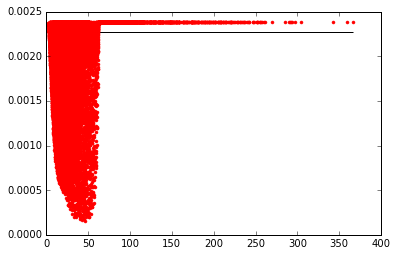

In [174]:
plt.plot(pff.Chi_1,pff['h0 ->  PHOT PHOT'],'r.')
plt.hlines(h_to_AA,pff.Chi_1.min(),pff.Chi_1.max())

* Collider constraints (check large mixing points with prospino)

In [79]:
cpf=hpf[hpf.LHC_cs_br<hpf.LHC_exc_cs]
cpf.shape

(7697, 201)

* STU constraints

* Indirect detection: $\langle\sigma v\rangle$

We will use arXiv:1504.04276 $\chi\overline{\chi}\to b\bar{b}$ constrains with Ein MAX profile frpm AMS-02

In [29]:
spf=lpf[lpf.z2_sigmav<lpf.AMS_ID_bb]
print spf.shape[0]

4623


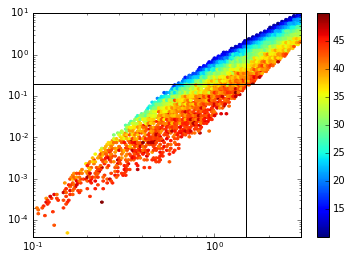

In [218]:
chimax=50
plt.hexbin(pf[pf.Chi_1<chimax].lam,pf[pf.Chi_1<chimax].T_par,pf[pf.Chi_1<chimax].Chi_1,yscale='log',xscale='log')
plt.hlines(0.2,0.1,3)
plt.vlines(1.5,4E-5,10)
plt.colorbar()

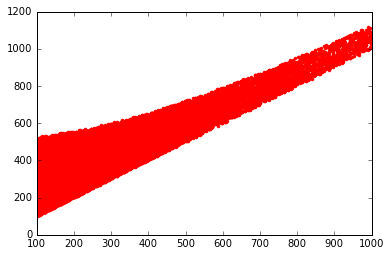

In [33]:
plt.plot(np.abs(pf.MDF),np.abs(pf.Chi_2),'r.')

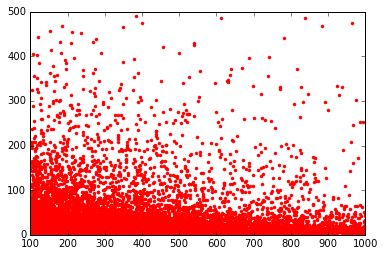

In [36]:
plt.plot(np.abs(pf.MDF),pf.lamdINPUT*a.vev,'r.')

TODO: The constraints in 1411.1335 are in the pure Higgsino limit. The quoted cross section is for either $\chi_2$ or $\chi_3$. 

I must:
* Use prospino to calculate the cross section for point wiht high mixing: $\lambda_{u,d}v\sim MD$
* Filter point not satisfying STU constraints

* Spin independent direct detection  LUX

In [77]:
lpf=pf[pf.z_DD_SI<pf.lux_SI]
print lpf.shape[0]

19071


* Invisible decay from LHC

In [78]:
hpf=lpf[lpf['h0 ->  Chi_1 Chi_1']<0.19]
hpf.shape

(8013, 201)

* Collider constraints (check large mixing points with prospino)

In [79]:
cpf=hpf[hpf.LHC_cs_br<hpf.LHC_exc_cs]
cpf.shape

(7697, 201)

* STU constraints

* Indirect detection: $\langle\sigma v\rangle$

We will use arXiv:1504.04276 $\chi\overline{\chi}\to b\bar{b}$ constrains with Ein MAX profile frpm AMS-02

In [29]:
spf=lpf[lpf.z2_sigmav<lpf.AMS_ID_bb]
print spf.shape[0]

4623


Points with rescaled relic density less than the Planck value

(7.1992306880000001, 366.50992100000002)

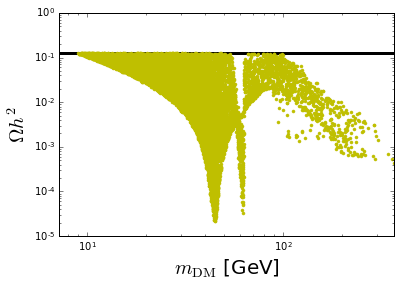

In [80]:
plt.loglog(pf.Chi_1,pf.Omega_h2,'y.')
plt.hlines(Omega_h2_EXP[2],1,1000,lw=3)#np.abs(pf.Chi_1).min(),np.abs(pf.Chi_1).max())
plt.ylabel(r'$\Omega h^2$',size=20)
plt.xlabel(r'$m_{\rm DM}$ [GeV]',size=20)
plt.xlim(np.abs(pf.Chi_1).min()*0.8,np.abs(pf.Chi_1).max())

Points with rescaled relic density less than the Planck value in the $\langle\sigma v\rangle$-$m_{\rm DM}$ plane

Blue line: xcluded region from 1504.04276 for $\chi\overline{\chi}\to b\overline{b}$ channel

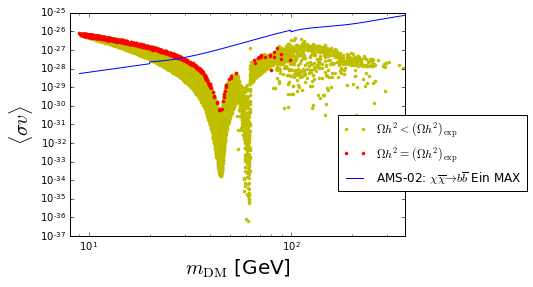

In [81]:
plt.loglog(pf.Chi_1,pf.z2_sigmav,'y.',label=r'$\Omega h^2<(\Omega h^2)_{\rm exp}$')
plt.loglog(opf.Chi_1,opf.z2_sigmav,'r.',label=r'$\Omega h^2=(\Omega h^2)_{\rm exp}$')
plt.loglog(pf.Chi_1,pf.AMS_ID_bb,label=r'AMS-02: $\chi\overline{\chi}\to b\overline{b}$ Ein MAX')
plt.xlim(pf.Chi_1.min()*0.9,pf.Chi_1.max())
plt.ylabel(r'$\langle\sigma v\rangle$',size=20)
plt.xlabel(r'$m_{\rm DM}$ [GeV]',size=20)
plt.legend(loc=(0.8,0.2))

rescaled direct detection constraint from LUX

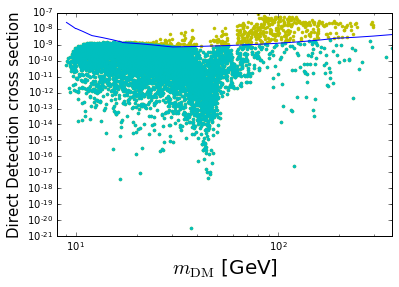

In [32]:
plt.loglog(pf.Chi_1,pf.z_DD_SI,'y.')
plt.loglog(lpf.Chi_1,lpf.z_DD_SI,'c.')
plt.loglog(pf.Chi_1,pf.lux_SI)
plt.xlim(pf.Chi_1.min()*0.9,pf.Chi_1.max())
plt.ylabel(r'Direct Detection cross section',size=15)
plt.xlabel(r'$m_{\rm DM}$ [GeV]',size=20)

Points which pass the rescaled direct detection constraint from LUX

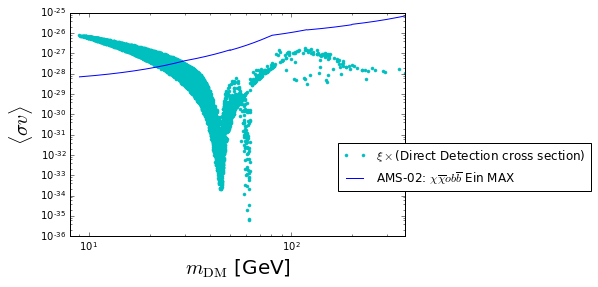

In [33]:
plt.loglog(lpf.Chi_1,lpf.z2_sigmav,'c.',label=r'$\xi\times $(Direct Detection cross section)')
plt.loglog(pf.Chi_1,pf.AMS_ID_bb,label='AMS-02: $\chi\overline{\chi}\to b\overline{b}$ Ein MAX')
plt.xlim(pf.Chi_1.min()*0.9,pf.Chi_1.max())
plt.ylabel(r'$\langle\sigma v\rangle$',size=20)
plt.xlabel(r'$m_{\rm DM}$ [GeV]',size=20)
plt.legend(loc=(0.8,0.2))

Points which pass the Higgs invisible decay  constraint from LHC: Br$(h\to \chi\overline{\chi})<0.19$

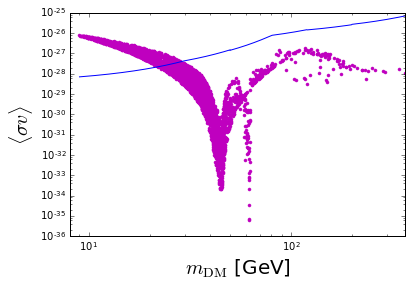

In [34]:
plt.loglog(hpf.Chi_1,hpf.z2_sigmav,'m.')
plt.loglog(pf.Chi_1,pf.AMS_ID_bb)
plt.xlim(pf.Chi_1.min()*0.9,pf.Chi_1.max())
plt.ylabel(r'$\langle\sigma v\rangle$',size=20)
plt.xlabel(r'$m_{\rm DM}$ [GeV]',size=20)

Points which pass the $R_{\gamma\gamma}$ constraint from LHC:

In [108]:
hpf.shape

(3203, 148)

In [109]:
haapf=hpf[np.logical_and(hpf['h0 ->  PHOT PHOT']/h_to_AA>R_AA[0],hpf['h0 ->  PHOT PHOT']/h_to_AA<R_AA[2])]
haapf.shape

(2812, 148)

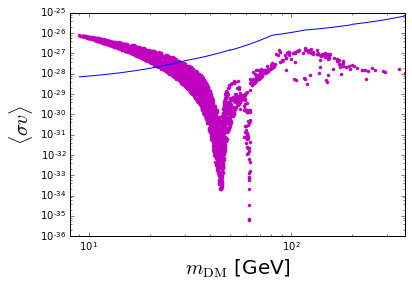

In [107]:
plt.loglog(haapf.Chi_1,haapf.z2_sigmav,'m.')
plt.loglog(pf.Chi_1,pf.AMS_ID_bb)
plt.xlim(pf.Chi_1.min()*0.9,pf.Chi_1.max())
plt.ylabel(r'$\langle\sigma v\rangle$',size=20)
plt.xlabel(r'$m_{\rm DM}$ [GeV]',size=20)

## STU parameters
https://fisica.udea.edu.co:4443/user/galcen/notebooks/gce_t13a.ipynb

(See also http://gfif.udea.edu.co:4443/user/rsiii/edit/RS3/IDM/rsiii_lhc_analysis/DM_scan.py)

New $V_{ij}$ elements : http://arxiv.org/abs/0705.4493

In [474]:
# %load run_feynrules_SDFM.py
#1. CHOOSE A BENCHMARK POINT  
#if 1==1:
#    MDF = 110.;MN = 101.;tanb = 10.0;lam = 0.15;v=246.2196; 
#def int_to_phys(MDF = 110.,MN = 101.,lu = 0.1,ld = 0.1,v=246.2196):
v=a.vev #-> V -> v/sqrt(2)
LAMBDA=1e+16

def PI0(m1,m2):
    pizero = 1./(16*np.pi**2)*( (m1-m2)**2*np.log(LAMBDA**4/(m1**2*m2**2))-2*m1*m2\
            +( 2*m1*m2*(m1**2+m2**2)-m1**4-m2**4 )/( m1**2-m2**2+1E-16 )*np.log(m1**2/m2**2) )
    return pizero

def PI0p(m1,m2):
    pizerop = 1./(24*np.pi**2)*( -np.log(LAMBDA**4/(m1**2*m2**2))\
             -m1*m2*(3*m1**2-4*m1*m2+3*m2**2)/(m1**2-m2**2+1E-16)**2\
             +( m1**6+m2**6-3*m1**2*m2**2*(m1**2+m2**2)+6*m1**3*m2**3 )\
                /(m1**2-m2**2+1E-10)**3*np.log(m1**2/m2**2)\
                               )
    return pizerop

def A(m1,m2):
    alpha = 1./128.
    return 1./(alpha*v**2)*PI0(m1,m2)   

def F(m1,m2):
    return 4*np.pi*PI0p(m1,m2)
class Atilde(object):
    def __init__(self,MDF,m):
        self.A=np.array( [ [A(m[0],m[0]),A(m[0],m[1]),A(m[0],m[2])],
            [A(m[1],m[0]),A(m[1],m[1]),A(m[1],m[2])],
            [A(m[2],m[0]),A(m[2],m[1]),A(m[2],m[2])],
            [A(MDF,m[0]),A(MDF,m[1]),A(MDF,m[2])]])
        self.minusA=np.array( [ [A(m[0],-m[0]),A(m[0],-m[1]),A(m[0],-m[2])],
                                [A(m[1],-m[0]),A(m[1],-m[1]),A(m[1],-m[2])],
                                [A(m[2],-m[0]),A(m[2],-m[1]),A(m[2],-m[2])],
                                [A(MDF, -m[0]),A(MDF, -m[1]),A(MDF, -m[2])]])
    def __getitem__(self,key):
        if type(key)==tuple:
            if len(key)==2 and key[1]=='-:':
                return self.minusA[key[0],:]
            else:
                return self.A[key]
        else:
            return self.A[key]
    def __call__(self,minus=False):
        if minus:
            return self.minusA
        else:
            return self.A

MDF = 100.;MN = 30.;lu = 1.1;ld = 1.5
mu=0.5*MN
alpha=(lu+ld)/np.sqrt(2)
beta=(lu-ld)/np.sqrt(2)
#alpha=0.65
#beta=0.65
if 1==1:
    M=np.array([[ MDF,      0,   -beta*v     ],
                [ 0,        -MDF,   -alpha*v ],
                [-beta*v, -alpha*v,  -2.*mu  ]])

    (m,V)=np.linalg.eig(M)
    lo=np.abs(m).argsort()
    #m=np.array([m[lo[0]],m[lo[1]],m[lo[2]]])
    #V=np.matrix(V)
    #V=np.asarray(np.hstack((V[:,lo[0]],V[:,lo[1]],V[:,lo[2]])))
    test=np.dot(np.dot(V.transpose(),M),V)
    At=Atilde(MDF,m)
    p=0;q=0
    for i in range(3):
        p=p+V[0,i]*V[0,i]*At()[3,i]+V[1,i]*V[1,i]*At(minus=True)[3,i]
        for j in range(3):
            q=q+(V[0,i]*V[1,j]+V[1,i]*V[0,j])**2*At(minus=True)[i,j]
    T=p-0.5*q
print T

-0.273669777779


In [475]:
test

array([[  9.47697882e+01,  -8.70414851e-14,   1.50990331e-14],
       [ -6.03961325e-14,   3.97863382e+02,   1.13686838e-13],
       [  0.00000000e+00,   5.68434189e-14,  -5.22633171e+02]])

In [443]:
start=time.time()
p=0
q=0
for i in range(3):
    p=p+V[0,i]**2*At()[3,i]+V[1,i]**2*At(minus=True)[3,i]
    for j in range(3):
            q=q+V[0,i]*V[0,i]*At(minus=True)[i,j]*V[1,j]*V[1,j]\
               +V[1,i]*V[1,i]*At(minus=True)[i,j]*V[0,j]*V[0,j]\
               +V[0,i]*V[1,i]*At(minus=True)[i,j]*V[0,j]*V[1,j]
print p
print q
print time.time()-start

1.70005588443
4.04723492684
0.00122284889221


In [448]:
start=time.time()

print p
print q
print time.time()-start

1.70005588443
4.04723492684
0.000939130783081


In [421]:
V[1,:]*V[1,:]

array([ 0.89866134,  0.        ,  0.10133866])

In [422]:
V

array([[ 0.        ,  1.        ,  0.        ],
       [-0.9479775 ,  0.        , -0.31833734],
       [ 0.31833734,  0.        , -0.9479775 ]])

In [398]:
At(minus=True)

array([[  6.69396367e+01,   2.31158157e-01,   1.63856483e+02],
       [  2.31158157e-01,   8.35199955e+01,   1.79189709e+01],
       [  1.63856483e+02,   1.79189709e+01,   3.08712761e+02],
       [  2.31158157e-01,   8.35199955e+01,   1.79189709e+01]])

In [326]:
At

array([[  -0.25842812,   74.13054529,   22.2118656 ],
       [  74.13054529,   -0.32356158,  176.25578452],
       [  22.2118656 ,  176.25578452,   -1.22110354],
       [  74.13054529,   -0.32356158,  176.25578452]])

In [330]:
At

array([  22.2118656 ,  176.25578452,   -1.22110354,  176.25578452])

In [387]:
At=Atilde(MDF,m)

In [388]:
At[1,'-:']

va1 (1, '-:')
va 1


array([  0.23115816,  83.51999555,  17.9189709 ])

In [389]:
At[1,:]

va1 (1, slice(None, None, None))


array([  74.13054529,   -0.32356158,  176.25578452])

In [380]:
Atm=np.array( [ [A(m[0],-m[0]),A(m[0],-m[1]),A(m[0],-m[2])],
                                [A(m[1],-m[0]),A(m[1],-m[1]),A(m[1],-m[2])],
                                [A(m[2],-m[0]),A(m[2],-m[1]),A(m[2],-m[2])],
                                [A(MDF, -m[0]),A(MDF, -m[1]),A(MDF, -m[2])]])

In [381]:
Atm[1,:]

array([  0.23115816,  83.51999555,  17.9189709 ])

In [217]:
#%%writefile stu1.py
x1['V11']=1./np.sqrt(2)*(-x1['N12']+x1['N13'])
x1['V21']=1./np.sqrt(2)*(-x1['N22']+x1['N33'])
x1['V31']=1./np.sqrt(2)*(-x1['N32']+x1['N33'])

x1['V12']=1./np.sqrt(2)*(x1['N12']+x1['N13'])
x1['V22']=1./np.sqrt(2)*(x1['N22']+x1['N33'])
x1['V32']=1./np.sqrt(2)*(x1['N32']+x1['N33'])

#Warning in the squared root
x1['V13']=1./np.sqrt(2)*x1['N11']
x1['V23']=1./np.sqrt(2)*x1['N21']
x1['V33']=1./np.sqrt(2)*x1['N31']

$\Pi(0)$ and $\Pi(0)'$ : http://arxiv.org/abs/0705.4493

In [243]:
#%%writefile stu2.py
v=a.vev

x1['T_par']=x1['V11']**2*A(x1['MDF'],x1['Mchi1'])\
            +x1['V12']**2*A(x1['MDF'],x1['Mchi2'])\
            +x1['V13']**2*A(x1['MDF'],x1['Mchi3'])\
            +x1['V21']**2*A(x1['MDF'],-x1['Mchi1'])\
            +x1['V22']**2*A(x1['MDF'],-x1['Mchi2'])\
            +x1['V23']**2*A(x1['MDF'],-x1['Mchi3'])\
            -1./2*(x1['V11']*x1['V21']+x1['V21']*x1['V11'])**2*A(x1['Mchi1'],-x1['Mchi1'])\
            -1./2*(x1['V11']*x1['V22']+x1['V21']*x1['V12'])**2*A(x1['Mchi1'],-x1['Mchi2'])\
            -1./2*(x1['V11']*x1['V23']+x1['V21']*x1['V13'])**2*A(x1['Mchi1'],-x1['Mchi3'])\
            -1./2*(x1['V12']*x1['V21']+x1['V22']*x1['V11'])**2*A(x1['Mchi2'],-x1['Mchi1'])\
            -1./2*(x1['V12']*x1['V22']+x1['V22']*x1['V12'])**2*A(x1['Mchi2'],-x1['Mchi2'])\
            -1./2*(x1['V12']*x1['V23']+x1['V22']*x1['V13'])**2*A(x1['Mchi2'],-x1['Mchi3'])\
            -1./2*(x1['V13']*x1['V21']+x1['V23']*x1['V11'])**2*A(x1['Mchi3'],-x1['Mchi1'])\
            -1./2*(x1['V13']*x1['V22']+x1['V23']*x1['V12'])**2*A(x1['Mchi3'],-x1['Mchi2'])\
            -1./2*(x1['V13']*x1['V23']+x1['V23']*x1['V13'])**2*A(x1['Mchi3'],-x1['Mchi3'])\

In [244]:
lu = 0.1;ld = 0.1
lam=np.sqrt(lu**2+ld**2)
tanb=lu/ld
stu.stumap(101.,110.,lam,tanb)

4.6220999152247066e-16

In [245]:
x1.T_par

78.43672114679228

In [223]:
stu.stumap?

Points which pass the collider constraints from LHC

In [113]:
expf=haapf[haapf.LHC_cs_br>haapf.LHC_exc_cs]
expf.shape

(122, 148)

In [36]:
1+1

2

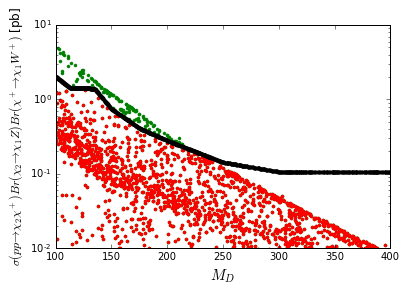

In [114]:
plt.semilogy(np.abs(hpf.MDF),hpf.LHC_cs_br,'g.')
#plt.semilogy(np.abs(expf.MDF),expf.LHC_cs_br,'b.')
plt.semilogy(np.abs(cpf.MDF),cpf.LHC_cs_br,'r.')
plt.semilogy(np.abs(cpf.MDF),cpf.LHC_exc_cs,'k.')
plt.xlim(100,400)
plt.ylim(0.01,10)
plt.xlabel(r'$M_D$',size=15)
plt.ylabel(r'$\sigma(pp\to \chi_2 \chi^+){Br}(\chi_2\to \chi_1 Z){Br}(\chi^+\to \chi_1 W^+)$ [pb]',size=12 )

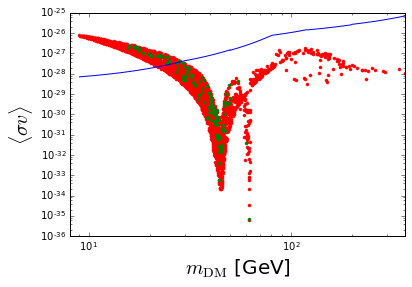

In [115]:
plt.loglog(cpf.Chi_1,cpf.z2_sigmav,'r.')
plt.loglog(expf.Chi_1,expf.z2_sigmav,'g.')
plt.loglog(pf.Chi_1,pf.AMS_ID_bb)
plt.xlim(pf.Chi_1.min()*0.9,pf.Chi_1.max())
plt.ylabel(r'$\langle\sigma v\rangle$',size=20)
plt.xlabel(r'$m_{\rm DM}$ [GeV]',size=20)

In [39]:
idb=pd.read_csv('ID_best.dat',header=None)
idb=idb.rename(columns={0:'MDF',1:'sigmav'})

In [40]:
idm=pd.read_csv('ID_med.dat',header=None)
idm=idm.rename(columns={0:'MDF',1:'sigmav'})

(1e-29, 1e-25)

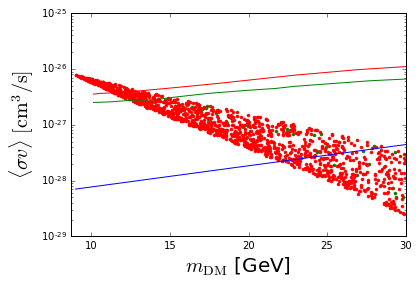

In [41]:
plt.semilogy(expf.Chi_1,expf.z2_sigmav,'g.')
plt.semilogy(cpf.Chi_1,cpf.z2_sigmav,'r.')
plt.semilogy(pf.Chi_1,pf.AMS_ID_bb)
plt.semilogy(idb.MDF,idb.sigmav)
plt.semilogy(idm.MDF,idm.sigmav)
plt.xlim(pf.Chi_1.min()*0.9,pf.Chi_1.max())
plt.ylabel(r'$\langle\sigma v\rangle\ [{\rm cm}^3/{\rm s}]$',size=20)
plt.xlabel(r'$m_{\rm DM}$ [GeV]',size=20)
plt.xlim(8.7,30)
plt.ylim(1E-29,1E-25)

## Conclusion
The FULL region excluded by indirect detection (above the blue line in previous) contains points which are not excluded by any other constraint. The upper part of the excluded region between 8 and 30 GeV have the proper relic density

In [42]:
spf=cpf[cpf.z2_sigmav>cpf.AMS_ID_bb]

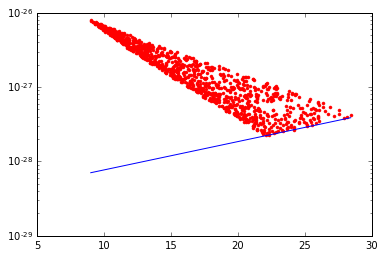

In [43]:
plt.semilogy(spf.Chi_1,spf.z2_sigmav,'r.')
plt.semilogy(spf.Chi_1,spf.AMS_ID_bb)


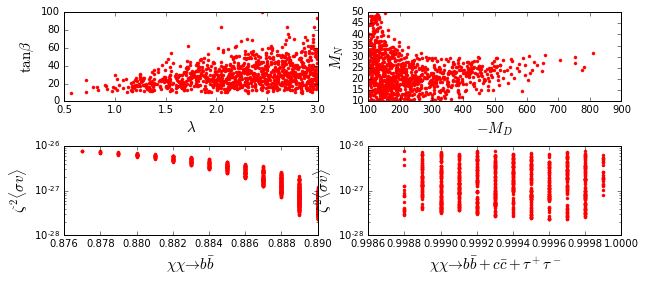

In [44]:
#fig, axes = plt.subplots(nrows=2, ncols=2)
#fig.tight_layout()
fig=plt.figure()
fig.subplots_adjust(hspace=0.5,wspace=0.2,left=0.01,right=1.3)
fig.add_subplot(221)
plt.plot(spf['lambda'],spf.tanb,'r.')
plt.xlabel(r'$\lambda$',size=15)
plt.ylabel(r'$\tan\beta$',size=15)
fig.add_subplot(222)
plt.plot(-spf.MDF,spf.MnINPUT,'r.')
plt.xlabel(r'$-M_D$',size=15)
plt.ylabel(r'$M_N$',size=15)
fig.add_subplot(223)
plt.semilogy(spf['ID_br:~chi,~chi > b b~'],spf.z2_sigmav,'r.')
plt.xlabel(r'$\chi\chi\to b\bar{b}$',size=15)
plt.ylabel(r'$\zeta^2\langle\sigma v\rangle$',size=15)
fig.add_subplot(224)
plt.semilogy(spf['ID_br:~chi,~chi > b b~']+spf['ID_br:~chi,~chi > c c~']+spf['ID_br:~chi,~chi > ta t'],spf.z2_sigmav,'r.')
plt.xlabel(r'$\chi\chi\to b\bar{b}+c \bar{c}+\tau^+\tau^-$',size=15)
plt.ylabel(r'$\zeta^2\langle\sigma v\rangle$',size=15)

Points satisfying all the constrains

In [ ]:
h_to_AA=2.270E-03
R_AA=np.array([1.15-0.25,1.15,1.15+0.27])

In [68]:
spf.shape

(1015, 148)

In [102]:
apf=spf[np.logical_or(spf['h0 ->  PHOT PHOT']/h_to_AA<R_AA[0],spf['h0 ->  PHOT PHOT']/h_to_AA>R_AA[2])]

In [80]:
plt.hlines?

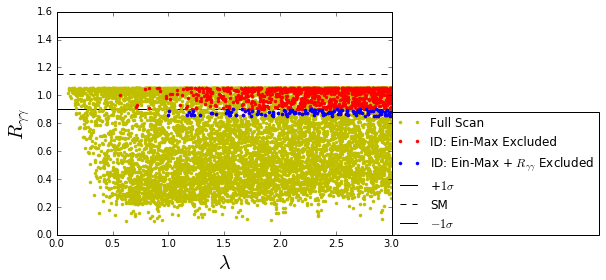

In [103]:
plt.plot(pf['lambda'],pf['h0 ->  PHOT PHOT']/h_to_AA,'y.',label='Full Scan')
plt.plot(spf['lambda'],spf['h0 ->  PHOT PHOT']/h_to_AA,'r.',label='ID: Ein-Max Excluded')
plt.plot(apf['lambda'],apf['h0 ->  PHOT PHOT']/h_to_AA,'b.',label=r'ID: Ein-Max + $R_{\gamma\gamma}$ Excluded')
plt.hlines(R_AA[0],0.,3,label=r'+$1\sigma$')
plt.hlines(R_AA[1],0.,3,linestyles='dashed',label='SM')
plt.hlines(R_AA[2],0.,3,label='$-1\sigma$')
plt.legend(loc=(1,0.))
plt.xlabel(r'$\lambda$',size=20)
plt.ylabel(r'$R_{\gamma\gamma}$',size=20)

(1e-29, 1e-25)

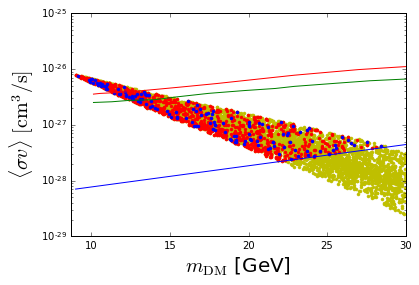

In [105]:
plt.semilogy(pf.Chi_1,pf.z2_sigmav,'y.')
plt.semilogy(spf.Chi_1,spf.z2_sigmav,'r.')
plt.semilogy(apf.Chi_1,apf.z2_sigmav,'b.')
plt.semilogy(pf.Chi_1,pf.AMS_ID_bb)
plt.semilogy(idb.MDF,idb.sigmav)
plt.semilogy(idm.MDF,idm.sigmav)
plt.xlim(pf.Chi_1.min()*0.9,pf.Chi_1.max())
plt.ylabel(r'$\langle\sigma v\rangle\ [{\rm cm}^3/{\rm s}]$',size=20)
plt.xlabel(r'$m_{\rm DM}$ [GeV]',size=20)
plt.xlim(8.7,30)
plt.ylim(1E-29,1E-25)

In [46]:
spf[['Omega_h2','sigmav','Chi_1','Chi_2','Fre','h0 ->  Chi_1 Chi_1','Chi_2 ->  Chi_1 Z0',\
     'Chi_3 ->  Chi_1 Z0','Fre ->  Chi_1 W-','lux_SI','proton_SI','neutron_SI','lambda','tanb',\
    'ID_br:~chi,~chi > b b~']]

,Omega_h2,sigmav,Chi_1,Chi_2,Fre,h0 -> Chi_1 Chi_1,Chi_2 -> Chi_1 Z0,Chi_3 -> Chi_1 Z0,Fre -> Chi_1 W-,lux_SI,proton_SI,neutron_SI,lambda,tanb,"ID_br:~chi,~chi > b b~"
1812,0.1240,7.310000e-27,8.999038,-471.681713,107.127998,0.070210,0.046995,0.009026,1.000000,2.523718e-08,4.756000e-11,4.865000e-11,2.718981,28.302810,0.877
1839,0.1230,7.270000e-27,9.045528,-475.985891,112.228979,0.134381,0.048825,0.010035,1.000000,2.420032e-08,9.784000e-11,1.001000e-10,2.765808,32.147723,0.877
1872,0.1230,7.190000e-27,9.130613,-446.362231,111.816231,0.118148,0.053979,0.012447,1.000000,2.241171e-08,8.453000e-11,8.647000e-11,2.571289,31.060117,0.877
1873,0.1230,7.190000e-27,9.132469,-511.401437,129.095496,0.182589,0.051289,0.014113,1.000000,2.237421e-08,1.409000e-10,1.442000e-10,2.956518,38.924593,0.878
1941,0.1220,7.060000e-27,9.289344,-494.850830,135.117957,0.115932,0.057576,0.019522,1.000000,1.942079e-08,8.291000e-11,8.481000e-11,2.808107,36.754167,0.878
1942,0.1180,7.320000e-27,9.290680,-442.504616,102.400253,0.003108,0.050054,0.010317,1.000000,1.939738e-08,1.971000e-12,2.017000e-12,2.487868,22.718408,0.878
1956,0.1170,7.360000e-27,9.318806,-463.668577,105.269420,0.001632,0.047999,0.010069,1.000000,1.891126e-08,1.034000e-12,1.057000e-12,2.605057,23.075454,0.878
1974,0.1240,6.860000e-27,9.361653,-512.047142,152.096147,0.063487,0.063757,0.027835,1.000000,1.819400e-08,4.290000e-11,4.388000e-11,2.852773,38.269077,0.878
1981,0.1230,6.930000e-27,9.381835,-373.859132,108.268832,0.089572,0.070345,0.019746,1.000000,1.786564e-08,6.227000e-11,6.370000e-11,2.112321,28.151603,0.878
2009,0.1240,6.800000e-27,9.442659,-385.809282,117.194408,0.034643,0.073682,0.026040,1.000000,1.691145e-08,2.273000e-11,2.325000e-11,2.142112,27.848437,0.879


In [54]:
spf[np.logical_and(spf.Omega_h2>0.11,spf['lambda']<0.8)][['Omega_h2','lambda']]

,Omega_h2,lambda
10311,0.121,0.711271


In [112]:
for k in spf.keys():
    if k.find('ID_br')>-1:
        print k,spf[k].max()

 ID_br:~chi,~chi > 0.0
ID_br:~chi,~chi > H H 0.0
ID_br:~chi,~chi > W W 0.0
ID_br:~chi,~chi > Z H 0.0
ID_br:~chi,~chi > Z Z 0.0
ID_br:~chi,~chi > a W 0.0
ID_br:~chi,~chi > b b~ 0.89
ID_br:~chi,~chi > c c~ 0.0743
ID_br:~chi,~chi > d d~ 0.0
ID_br:~chi,~chi > mu m 0.000174
ID_br:~chi,~chi > s s~ 0.000478
ID_br:~chi,~chi > t t~ 0.0
ID_br:~chi,~chi > ta t 0.048
ID_br:~chi,~chi > u u~ 0.0
ID_br:~chi,~chi > v v 0.0
ID_br:~chi,~chi > vm vm 0.0
ID_br:~chi,~chi > vt vt 0.0


In [109]:
k='ID_br:~chi,~chi > v v'
k.find('ID_br')

0

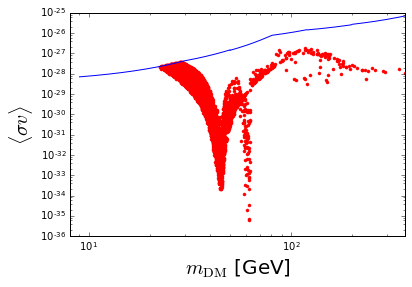

In [152]:
plt.loglog(spf.Chi_1,spf.z2_sigmav,'r.')
plt.loglog(pf.Chi_1,pf.AMS_ID_bb)
plt.xlim(pf.Chi_1.min()*0.9,pf.Chi_1.max())
plt.ylabel(r'$\langle\sigma v\rangle$',size=20)
plt.xlabel(r'$m_{\rm DM}$ [GeV]',size=20)

(1e-28, 1e-26)

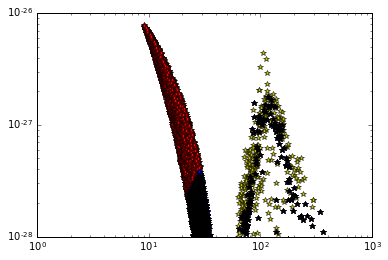

In [87]:

plt.loglog(pf.Chi_1,pf.z2_sigmav,'y*')
plt.loglog(ppf.Chi_1,ppf.z2_sigmav,'r*')
plt.loglog(svf.Chi_1,svf.z2_sigmav,'b*')
plt.loglog(hsv.Chi_1,hsv.z2_sigmav,'k*')
#plt.loglog(hpf[hpf.Fre>400].Chi_1,hpf[np.abs(hpf.Fre)>400].z2_sigmav,'b*')
#plt.plot(ppf.Chi_1) #From 1504.04276 see also 1508.06844
plt.ylim(1E-28,1E-26)

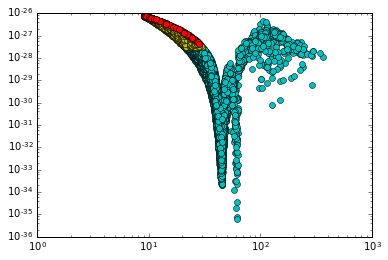

In [22]:
fpf=hpf[np.logical_and(hpf.Chi_1<60,hpf.z2_sigmav>3E-28)]
opf=fpf[np.logical_and(fpf.Omega_h2<Omega_h2_EXP[2],fpf.Omega_h2>Omega_h2_EXP[0])]
plt.loglog(pf.Chi_1,pf.z2_sigmav,'co')
plt.loglog(fpf.Chi_1,fpf.z2_sigmav,'yo')
plt.loglog(opf.Chi_1,opf.z2_sigmav,'ro')

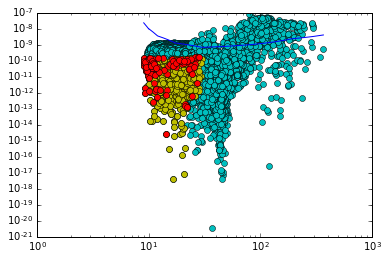

In [23]:
plt.loglog(pf.Chi_1,pf.z_DD_SI,'co')
plt.loglog(fpf.Chi_1,fpf.z_DD_SI,'yo')
plt.loglog(opf.Chi_1,opf.z_DD_SI,'ro')
plt.loglog(pf.sort_values('Chi_1').Chi_1,pf.sort_values('Chi_1').lux_SI,'b-')


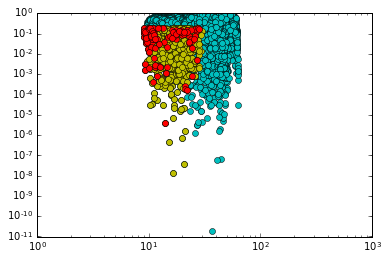

In [24]:
plt.loglog(pf.Chi_1,pf['h0 ->  Chi_1 Chi_1'],'co')
plt.loglog(fpf.Chi_1,fpf['h0 ->  Chi_1 Chi_1'],'yo')
plt.loglog(opf.Chi_1,opf['h0 ->  Chi_1 Chi_1'],'ro')

In [185]:
%%writefile stu_sdfdm.py
#!/usr/bin/env python
'''
STU analisis for SDFDM model arXiv:1411.1335
TODO: Only T included
return: array of T paremeter
'''
from numpy import *
import commands
import numpy as np
import sys
import scipy as sp
import scipy.integrate as integrate
from scipy.integrate  import quad
import scipy.optimize

## Calculate B0 for p**2=0
def B00(m1,m2):
    bb00=1.0-(m1**2*log(m1**2)-m2**2*log(m2**2))/(m1**2-m2**2)
    return bb00

# Function to calculate B0
def logDelta(x,pp,m1,m2):
    yy=x*m1**2+(1.0-x)*m2**2-x*(1.0-x)*pp**2
    return np.log(yy)

## Calculate B0 for p**2 neq 0
def B0(pp,m1,m2):
    yy=-np.asarray(quad( logDelta, 0.0, 1.0, args=(pp,m1,m2) ))
    return yy[0]

# Function to calculate H
def f1(x,pp,m1,m2):
    f2=( 4.0*x*(1.0-x)*pp**2 - 2.0*(1.0-x)*m1**2 - 2.0*x*m2**2)*logDelta(x,pp,m1,m2)
    return f2

## Calculate H for arbitrary p**2
def HH(pp,m1,m2):
    hh=-np.asarray(quad( f1, 0.0, 1.0, args=(pp,m1,m2) ))
    return hh[0]



def stu(ms,md,ll,tbeta,vev=246,sw=sqrt(0.23),mz=91.18,gg=0.653):
            
    r2=np.sqrt(2.0)
    cw=sqrt(1.-sw**2)
    mw=mz*cw
    ee=gg*sw
    alpha=ee**2/(4.0*np.pi)

    yy=ll*cos(arctan(tbeta))  #random.uniform(0.1,10)
    yyp=ll*sin(arctan(tbeta))# random.uniform(0.1,10)
 
    #Mass matrix from arXiv:1411.1335, eq(12). Fix a global sign in Lagrangian, e.g L -> -L and MN -> -ms
    Mmass=[[-ms, -yy*vev/r2, yyp*vev/r2],[yy*vev/r2, 0.0, -md], [-yyp*vev/r2, -md, 0]]
    eigsys=np.linalg.eigh(Mmass)
    eigva=eigsys[0]
    UU0=eigsys[1]
 
    if(abs(eigva[0])<abs(eigva[1])and abs(eigva[0])<abs(eigva[2])):
        masses=eigva
        UU=UU0
    if(abs(eigva[1])<abs(eigva[0])and abs(eigva[1])<abs(eigva[2])):
        vecs=np.transpose(UU0)
        VV=[vecs[1], vecs[0], vecs[2]]
        UU=np.transpose(VV)
        masses=[eigva[1],eigva[0],eigva[2]]
    if(abs(eigva[2])<abs(eigva[0])and abs(eigva[2])<abs(eigva[1])):
        vecs=np.transpose(UU0)
        VV=[vecs[2], vecs[0], vecs[1]]
        UU=np.transpose(VV)
        masses=[eigva[2],eigva[0],eigva[1]]
 
    #Inputs for the ST parameters: eq(16) from arXiv:1411.1335. 
    Cli = np.asarray([UU[2][0], UU[2][1], UU[2][2]])/r2
    Cri = -1.0*np.asarray([UU[1][0], UU[1][1], UU[1][2]])/r2
    Nlij=[[0.0,0.0,0.0], [0.0,0.0,0.0], [0.0,0.0,0.0]]
    for ii in range(3):
        for jj in range(3):
            Nlij[ii][jj]=-0.5*(UU[2][ii]*UU[2][jj]-UU[1][ii]*UU[1][jj])
    Nrij=-1.0*np.asarray(Nlij)
 
    #Calculating T parameter
    #W vacuum polarization 
    PiWW0=0
    chk=0
    for ii in range(3):
        PiWW0=PiWW0-gg**2/(16.0*np.pi**2)*( (Cli[ii]**2+Cri[ii]**2)*HH(0.0,masses[ii],md) + 4.0*Cli[ii]*Cri[ii]*md*masses[ii]*B0(0.0,masses[ii],md) )
        chk=chk+Cli[ii]*Cri[ii]*md
    
    #Z vacuum polarization 
    PiZZ01=-gg**2*(1.0-2.0*sw**2)**2/(32.0*np.pi**2*cw**2)*( HH(0.0,md,md) + 2.0*md**2*B0(0.0,md,md))
 
    PiZZ02=0
    for ii in range(3):
            for jj in range(3):
                PiZZ02=PiZZ02-gg**2/(32.0*np.pi**2*cw**2)*( ( Nlij[ii][jj]**2 + Nrij[ii][jj]**2 )*HH(0.0,masses[ii],masses[jj]) )
                
    PiZZ03=0
    for ii in range(3):
        for jj in range(3):
            PiZZ03=PiZZ03-gg**2/(32.0*np.pi**2*cw**2)*4.0*( Nlij[ii][jj]*Nrij[jj][ii]*masses[ii]*masses[jj]*B0(0.0,masses[ii],masses[jj]) )
 
    #T parameter        
    TT=1.0/(alpha*mw**2)*( PiWW0 - (PiZZ01+PiZZ02+PiZZ03)*cw**2 )
   
    return TT




def stumap(MN=33.030735, MDF=-331.061482,lam=0.76006,tanb=19.231293,vev=246,sw=sqrt(0.23),mz=91.18,gg=0.653):
    MN=np.asarray(MN)
    MDF=np.asarray(MDF)
    lam=np.asarray(lam)
    tanb=np.asarray(tanb)
    if not MN.shape:
        MN=np.asarray([MN])
        MDF=np.asarray([MDF])
        lam=np.asarray([lam])
        tanb=np.asarray([tanb])
            
    if np.unique([MN.shape[0],MDF.shape[0],lam.shape[0],tanb.shape[0]]).shape[0]>1:
        sys.exit('ERROR: Input parameters have different dimensions')
    
    T=[]    
    for i in range(MN.shape[0]):
        ms=MN[i] #random.uniform(10,50) #Singlet mass parameter
        md=MDF[i] #random.uniform(100,900)*(-1)**(random.random_integers(1,2)) #Doublet mass parameter
        ll=lam[i] #0.76006 #random.uniform(0.5,3.0) #Yukawa coupling
        tbeta=tanb[i] #10**((log10(60.))*np.random.uniform(0,1)) #tbeta=yyp/yy
        T.append(stu(ms,md,ll,tbeta,vev=vev,sw=sw,mz=mz,gg=gg))

    if len(T)==1:
        return T[0]
    else:
        return np.asarray(T)


Overwriting stu_sdfdm.py


In [174]:
chk=pf
chk=chk.reset_index(drop=True)
chk['lam']=chk['lambda']
#print chk.MnINPUT.values,chk.MDF.values,chk.lam.values,chk.tanb.values
tt=stumap(chk.MnINPUT.values,chk.MDF.values,chk.lam.values,chk.tanb.values)

In [176]:
tt.min()

7.9713948651098533e-06

In [142]:
for i in range(MN.shape[0]): print i

0


In [139]:
np.unique([MN.shape[0],MDF.shape[0],lam.shape[0],tanb.shape[0]]).shape[0]

1

-8.52651282912e-14 1.11235643823 -77.3688325165 76.2564760783 -0.00335996936734 -331.061482


-8.52651282912e-14 1.11235643823 -77.3688325165 76.2564760783 0.00335996936734 331.061482

In [90]:
pd.read_csv('scanSTU2.txt',sep=' ',names=['MD','MN','lambda','tanb','Chi_1','Chi_2','Chi_3','T'])

,MD,MN,lambda,tanb,Chi_1,Chi_2,Chi_3,T
0,-331.061482,33.030735,0.76006,-19.231293,23.723284,-352.171086,361.478536,0.081


In [ ]:
-8.52651282912e-14 0.00335996936734 331.061482

from http://arxiv.org/pdf/1505.03867v2.pdf fig 8
<img src="https://inspirehep.net/record/1370447/files/lowmass_1_m20.png">

In [543]:
start=time.time()
if 1==1:
    pf=pd.DataFrame()
    fulld=pd.DataFrame()
    v=a.vev
    #lambda_1=0.13
    mdf=-200; MN=40; tanb=100.;lam=0.35
    npoints=5000
    i=0
    for mdf in -np.logspace(np.log10(100),np.log10(1000),npoints):
        mdf=mdf*np.random.choice([1,-1])
        i=i+1
        if i%1000==0: print i
        ps=pd.Series()
        MN=np.exp(np.random.uniform(np.log(1),np.log(500)))
        tanb=20 #np.random.uniform(1,100)
        lam=1. #np.random.uniform(0.1,3)
        lu=lam*np.sin(np.arctan(tanb))
        ld=lam*np.cos(np.arctan(tanb))
        devnull=commands.getoutput('rm -f SPheno.spc.%s' %a.MODEL)
        a.LHA.blocks['SPHENOINPUT'].entries[55]='0               # Calculate one loop masses'
        a.LHA.blocks['MINPAR'][2]='%0.8E       # MDF' %mdf
        a.LHA.blocks['MINPAR'][3]='%0.8E       # MnINPUT' %MN
        a.LHA.blocks['MINPAR'][4]='%0.8E       # lamuINPUT' %lu
        a.LHA.blocks['MINPAR'][5]='%0.8E       # lamdINPUT' %ld
        moc=a.runmicromegas(Direct_Detection=True)
        #print 'Omega h^2, SI proton, neutron, MChi =',a.Series.Omega_h2,a.Series.proton_SI,a.Series.neutron_SI,\
        a.LHA_out.blocks['MASS'][a.pdg.pdg_name.Chi_1]
    #manual pdgs:
        a.pdg['Frep']=-210000601
        #mof=run_feynrules_SDFDM(MDF = -a.Series.MDF,MN = a.Series.MnINPUT,\
        #                    lu = a.Series.lamuINPUT,ld = a.Series.lamdINPUT ,v=a.vev)
    #implement sigma_v
        #mo=a.micromegas_output(mof['Full'])
        a.branchings(a.LHA_out.decays,min_pdg=23) #Fill a.Br_names

                
        #print 'Omega h^2, SI proton, sigmav,Br_inv  =',mo.Omega_h2,mo.proton.SI,mo.sigmav,a.Br_names['h0 ->  Chi_1 Chi_1']
        #print a.Br_names['Fre ->  Chi_1 W-'],a.Br_names['Cha.Seriesi_2 ->  Chi_1 Z0']
        a.Series['sigma_chi0_chipm']=0.3 #pb from fig. 15 of arXiv:1411.1335
        a.Series['Chi_1']=a.LHA_out.blocks['MASS'][a.pdg.pdg_name.Chi_1]
        a.Series['Chi_2']=a.LHA_out.blocks['MASS'][a.pdg.pdg_name.Chi_2]
        a.Series['Chi_3']=a.LHA_out.blocks['MASS'][a.pdg.pdg_name.Chi_3]
        a.Series['Fre']=a.LHA_out.blocks['MASS'][a.pdg.pdg_name.Fre]
        ps=ps.append(a.Series)
        ps=ps.append(a.Br_names)
        #ps=ps.append(  mo.rename( {'Omega_h2':'Omega_h2_mo','proton_SI':'proton_SI_mo','neutron_SI':'neutron_SI_mo',\
        #                           'proton_SD':'proton_SD_mo','neutron_SD':'neutron_SD_mo','sigmav':'sigmav_mo',\
        #                             } )  )
        
        pf=pf.append(ps,ignore_index=True)
        pf=pf.fillna(0)
        #Full backup of data: WARNING: HUGE File
        fulls=pd.Series()
        if os.path.isfile('SPheno.spc.%s' %a.MODEL):
            f=open('SPheno.spc.%s' %a.MODEL).read()
            fulls['SPheno']=f
            fulls['micromegas']=moc
            
        fulld=fulld.append(fulls,ignore_index=True)

stop=time.time()
trun=stop-start
pd.DataFrame({'t':[trun]}).to_csv('trun.csv')

1000
2000
3000
4000
5000


In [554]:
import pandas as pd

In [553]:
if scan:
    pf.to_csv('fig8.csv',index=False)
    pf.shape

(5519, 172)

In [555]:
pf=pd.read_csv('fig8.csv')
#pf=pf.append( pd.read_csv('fig8_2.csv') )
pf=pf[pf.MDF<0]
pf.shape

(3012, 172)

In [556]:
pf['z2_sigmav']=pf.Omega_h2**2/Omega_h2_EXP[1]**2*pf.sigmav #sigmav calculated from feynrules implemenation
pf['tanb']=pf.lamuINPUT/pf.lamdINPUT
pf['lambda']=np.sqrt(pf.lamuINPUT**2+pf.lamdINPUT**2)
pf['lam']=pf['lambda']
pf['T_par']=stu.stumap(pf.MnINPUT.values,pf.MDF.values,pf.lam.values,pf.tanb.values,vev=a.vev)
pf['DD_SI']=0
if pf[pf.proton_SI>pf.neutron_SI].shape[0]==0:
    pf['DD_SI']=pf.neutron_SI
else:
    for i in range(pf.shape[0]):
        pf=pf.reset_index(drop=True)
        pf.loc[i,'DD_SI']=max(pf.proton_SI[i],pf.neutron_SI[i])
pf['z_DD_SI']=pf.Omega_h2/Omega_h2_EXP[1]*pf.DD_SI
LUX=multicurvefit()
LUX.read_json('lux2016.json')
pf['lux_SI']=LUX(pf.Chi_1,verbose=False)

In [557]:
f8=pf
nl=17
print '-'*nl
print '| all |', pf.shape[0],'  |'
cf=pd.Series()
cf['a']=f8[f8.Omega_h2>Omega_h2_EXP[2]]
print '-'*nl
print '| a   |', cf.a.shape[0],'  |'
cf['b']=f8[f8.T_par>0.2]
print '-'*nl
print '| b   |', cf.b.shape[0],'  |'
cf['c']=cf.b[cf.b['h0 ->  Chi_1 Chi_1']<0.19]
print '-'*nl
print '| c   |', cf.c.shape[0],'  |'
#cf['d']=f8[np.logical_and(cf.c['h0 ->  PHOT PHOT']/h_to_AA>R_AA[0],cf.c['h0 ->  PHOT PHOT']/h_to_AA<R_AA[2])]
#print '-'*nl
#print '| d   |', cf.d.shape[0],'  |'
#cf['e']=cf.d[cf.d.LHC_cs_br<cf.d.LHC_exc_cs]
#print '-'*nl
#print '| e   |', cf.e.shape[0],'  |'
cf['f']=f8[f8.z_DD_SI<f8.lux_SI]
print '-'*nl
print '| f   |', cf.f.shape[0],'   |'
print '-'*nl


-----------------
| all | 3012   |
-----------------
| a   | 1876   |
-----------------
| b   | 1432   |
-----------------
| c   | 605   |
-----------------
| f   | 1240    |
-----------------


In [558]:
of8=Oh2(f8)

(0, 300)

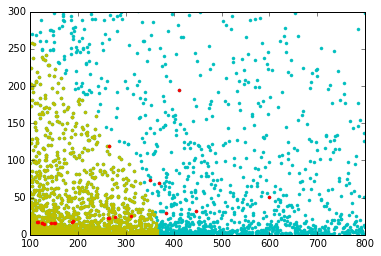

In [562]:
plt.plot(f8.MDF.abs(),f8.MnINPUT,'c.')
plt.plot(cf.b.MDF.abs(),cf.b.MnINPUT,'y.')
plt.plot(of8.MDF.abs(),of8.MnINPUT,'r.')
plt.xlim(100,800)
plt.ylim(0,300)

[Jupyter home](./draft.pdf)